In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import time
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )

In [2]:
def get_all_performances(value_train, values_test, metrics):
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

METRICS = [r2_score,
           mean_squared_error,
           mean_absolute_percentage_error,
           max_error,
          ]

In [ ]:
X_train = pd.read_csv('./bases/Feature_Eng_res.csv')

In [6]:
X_train.head(5)

,date_block_num,shop_id,item_category_id,item_id,item_cnt_month,cat_lag_1,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,...,date_category_avg_item_cnt_month_lag_3,date_shop_category_avg_item_cnt_month_lag_1,date_shop_category_avg_item_cnt_month_lag_2,date_shop_category_avg_item_cnt_month_lag_3,date_avg_item_price_lag_1,date_avg_item_price_lag_2,date_avg_item_price_lag_3,date_shop_avg_item_price_lag_1,date_shop_avg_item_price_lag_2,date_shop_avg_item_price_lag_3
0,3,2,37,31,1.0,False,1.0,4.0,0.0,1.926,...,0.000000,1.000000,1.500000,0.0,688.5,667.0,519.0,698.5,699.0,525.0
1,3,2,49,464,1.0,False,0.0,0.0,0.0,0.000,...,0.000000,0.000000,0.000000,0.0,299.0,299.0,294.8,299.0,299.0,299.0
2,3,2,73,482,1.0,False,1.0,1.0,1.0,1.926,...,2.644898,1.285714,1.666667,1.4,3234.0,3192.0,3186.0,3300.0,3300.0,3300.0
3,3,2,73,484,3.0,False,2.0,4.0,2.0,1.926,...,2.644898,1.285714,1.666667,1.4,298.5,291.5,286.2,300.0,300.0,300.0
4,3,2,73,485,2.0,False,0.0,0.0,0.0,0.000,...,0.000000,0.000000,0.000000,0.0,297.2,2196.0,2176.0,291.8,2236.0,2232.0


# Random Forest

In [7]:
X_randF = X_train.copy()
# Transformer les var shop_id et item_category_id en numérique pour les inclure dans notre modèle
X_randF[['shop_id','item_category_id']]=X_randF[['shop_id','item_category_id']].astype(object)
X_randF = X_randF.drop(['item_id'],axis=1)

vars = X_randF.select_dtypes(include=['object']).columns
for var in vars:
    tmp = pd.get_dummies(X_randF[var] , prefix=var,drop_first=True)
    X_randF = X_randF.join(tmp)

del tmp
    
X_randF_train = X_randF[X_randF.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_randF_train = X_randF[X_randF.date_block_num < 33]['item_cnt_month']
X_randF_valid = X_randF[X_randF.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_randF_valid = X_randF[X_randF.date_block_num == 33]['item_cnt_month']

X_randF_train = X_randF_train.drop(['shop_id','date_block_num','item_category_id'],axis=1)
X_randF_valid = X_randF_valid.drop(['shop_id','date_block_num','item_category_id'],axis=1)

del X_randF


In [8]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
# Modèle de regression Random Forest
Model_RF = RandomForestRegressor(
        n_estimators=300, #c
        criterion='mse', 
        max_depth=15, #c
        verbose=1, #c
        # max_features = 'sqrt',
        random_state=0 ,
        n_jobs=-1)

Model_RF.fit(X_randF_train, Y_randF_train)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 71.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 108.7min finished


RandomForestRegressor(criterion='mse', max_depth=15, n_estimators=300,
                      n_jobs=-1, random_state=0, verbose=1)

In [13]:
# Prédiction et Evaluation du modèle
Y_randF_valid_pred = Model_RF.predict(X_randF_valid)
Y_randF_train_pred = Model_RF.predict(X_randF_train)

# Métriques d'evaluation
get_all_performances(value_train=(Y_randF_train, Y_randF_train_pred),
                     values_test=(Y_randF_valid, Y_randF_valid_pred),
                     metrics=METRICS)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:   35.5s finished


,metric,train,test
0,r2_score,0.937039,0.872640
1,mean_squared_error,3.852808,4.223062
2,mean_absolute_percentage_error,0.495027,0.501054
3,max_error,383.628125,84.751184


In [14]:
del X_randF_train , X_randF_valid , Y_randF_train , Y_randF_valid , Y_randF_valid_pred , Y_randF_train_pred , Model_RF

## LIGHTGBM

In [15]:
import lightgbm as lgb

In [4]:
data = X_train.copy()
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

In [19]:
%%time
feature_names = X_train.drop(['date_block_num'],axis=1).columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 255,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1,
    'force_row_wise' : True
}

categorical_feature_names = [ 
                            'shop_id',
                            'item_id',
                            #'date_block_num' # enlever ou pas
                            'item_category_id',
                            'cat_lag_1'
                            
                            ]

lgb_train = lgb.Dataset(X_train[feature_names], Y_train, categorical_feature=None)
lgb_eval  = lgb.Dataset(X_valid[feature_names], Y_valid, categorical_feature=None, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round = 4000,
        valid_sets = (lgb_train, lgb_eval), 
        feature_name = feature_names,
        categorical_feature = categorical_feature_names,
        verbose_eval = 100, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 5.54728	valid_1's rmse: 3.8621
[200]	training's rmse: 4.30777	valid_1's rmse: 2.84515
[300]	training's rmse: 3.66466	valid_1's rmse: 2.38425
[400]	training's rmse: 3.30801	valid_1's rmse: 2.18867
[500]	training's rmse: 3.09087	valid_1's rmse: 2.12274
[600]	training's rmse: 2.94016	valid_1's rmse: 2.11153
Early stopping, best iteration is:
[590]	training's rmse: 2.95339	valid_1's rmse: 2.1059
CPU times: user 12min 39s, sys: 3.45 s, total: 12min 43s
Wall time: 6min 42s


In [20]:
#X_train.drop(['date_block_num'],axis=1)
y_valid_pred = gbm.predict(X_valid.drop(['date_block_num'],axis=1))
y_train_pred = gbm.predict(X_train.drop(['date_block_num'],axis=1))

In [21]:
get_all_performances(value_train=(Y_train, y_train_pred),
                     values_test=(Y_valid, y_valid_pred),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.857460,0.866187
1,mean_squared_error,8.722490,4.437038
2,mean_absolute_percentage_error,0.458900,0.539971
3,max_error,910.443698,93.106561


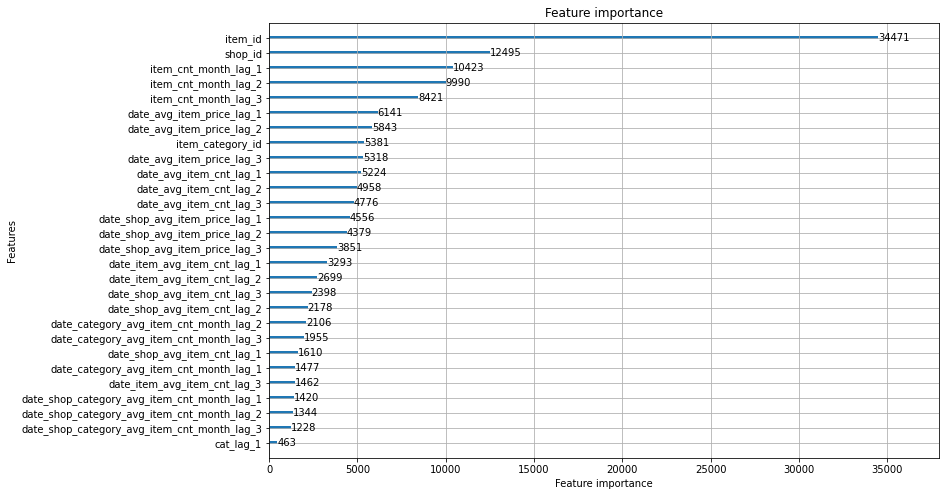

In [24]:
ax = lgb.plot_importance(gbm, figsize=(12, 8))
plt.show()

In [5]:
del X_train , X_valid , Y_train , Y_valid , gbm

## XGBOOST

In [6]:
from xgboost import XGBRegressor

In [7]:
X_XGB = data.copy()
X_XGB[['shop_id','item_category_id']]=X_XGB[['shop_id','item_category_id']].astype(object)
X_XGB = X_XGB.drop(['item_id'],axis=1)

vars = X_XGB.select_dtypes(include=['object']).columns
for var in vars:
    tmp = pd.get_dummies(X_XGB[var] , prefix=var,drop_first=True)
    X_XGB = X_XGB.join(tmp)



X_XGB_train = X_XGB[X_XGB.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_XGB_train = X_XGB[X_XGB.date_block_num < 33]['item_cnt_month']
X_XGB_valid = X_XGB[X_XGB.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_XGB_valid = X_XGB[X_XGB.date_block_num == 33]['item_cnt_month']

X_XGB_train = X_XGB_train.drop(['shop_id','date_block_num','item_category_id'],axis=1)
X_XGB_valid = X_XGB_valid.drop(['shop_id','date_block_num','item_category_id'],axis=1)
del tmp , X_XGB
#X_XGB_train

In [9]:
%%time
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_XGB_train, 
    Y_XGB_train, 
    eval_metric="rmse", 
    eval_set=[(X_XGB_train, Y_XGB_train),(X_XGB_valid, Y_XGB_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[05:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.33868	validation_1-rmse:5.472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.76618	validation_1-rmse:5.07521
[2]	validation_0-rmse:6.26523	validation_1-rmse:4.67154
[3]	validation_0-rmse:5.80506	validation_1-rmse:4.25835
[4]	validation_0-rmse:5.38799	validation_1-rmse:3.95391
[5]	validation_0-rmse:5.02096	validation_1-rmse:3.69281
[6]	validation_0-rmse:4.68892	validation_1-rmse:3.48145
[7]	validation_0-rmse:4.3942	validation_1-rmse:3.25996
[8]	validation_0-rmse:4.13207	validation_1-rmse:3.08849
[9]	validation_0-rmse:3.9023	validation_1-rmse:2.93133
[10]	validation_0-rmse:3.68473	validation_1-rmse:2.83776
[11]	validation_0-rmse:3.49487	validation_1-rmse:2.71537
[12]	validation_0-rmse:3.31848	validation_1-

XGBRegressor(colsample_bytree=0.8, eta=0.1, max_depth=10, min_child_weight=0.5,
             n_estimators=1000, seed=42, subsample=0.8)

In [10]:
%%time
y_valid_pred = model.predict(X_XGB_valid)
y_train_pred = model.predict(X_XGB_train)

get_all_performances(value_train=(Y_XGB_train, y_train_pred),
                     values_test=(Y_XGB_valid, y_valid_pred),
                     metrics=METRICS
                    )

CPU times: user 19.1 s, sys: 1.31 s, total: 20.4 s
Wall time: 21 s


,metric,train,test
0,r2_score,0.947568,0.853243
1,mean_squared_error,3.208480,4.866232
2,mean_absolute_percentage_error,0.494736,0.509508
3,max_error,177.650452,188.660904


In [11]:
del X_XGB_train,Y_XGB_train , X_XGB_valid , Y_XGB_valid , model